<a href="https://colab.research.google.com/github/BrianKipngeno/Cancer-tweets-classification/blob/main/Cancer_disease_tweets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have following dataset that is a tsv file. Let's create a classification model that can predict whether a tweet talks about a cancer disease


Dataset URL = https://bit.ly/3h2hDuw

### Prerequisites

In [ ]:
# Importing required libraries

# Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja
from textblob import TextBlob
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Lemmatization
nltk.download('wordnet')
from textblob import Word

# Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Utility Functions

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

### Step 1: Data exploration

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Data Importation
# ---
#
df = pd.read_csv('https://bit.ly/3h2hDuw', sep = '\t')
df.columns = ['text', 'target']
df.head()

,text,target
0,RT @TommySobiesski: you could give GameStop th...,no
1,This last year has been the hardest of my life...,no
2,The year is 2043. You opened your newspaper an...,no
3,RT @gorskon: Here we go again. Yet another dub...,no
4,So sick of festival kids fingering themselves ...,no


In [ ]:
# We can determine the size of our dataset
# ---
#
df.shape

(1506, 2)

In [ ]:
# To get an understanding of our dataset lets sample 10 records
# ---
#
df.sample(5)

,text,target
29,The major demand for rhino horn is in Asia whe...,yes
161,RT @tori_schlabig: he’s gonna disappear faster...,no
524,@_IamAnita_D @kwilli1046 Democrats don't want ...,no
177,RT @MirrorWeirdNews: Woman swears by drinking ...,yes
47,@UPSHelp my 4 month old son has terminal brain...,yes


In [ ]:
# Because this dataset is abit large, we will consider working with
# random sample of 200 records. This is for demo purposes because
# a large dataset would take a long time to perform some text
# processing techniques.
# ---
#
sample_df = df.sample(200)
sample_df.head()

,text,target
59,@Devarshi_21 @sharma_jyo @MohitKu89856580 @swe...,yes
596,@HomunculusLoikm I agree with @elonmusk mindin...,no
695,@MeghanMcCain There is a lot of advancements t...,yes
1310,https://t.co/fT8D6bqSVU Great job by the ladie...,no
1035,What if the cure for cancer is trapped inside ...,no


This dataset will need some data cleaning i.e. removal of links, hashtags, etc.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

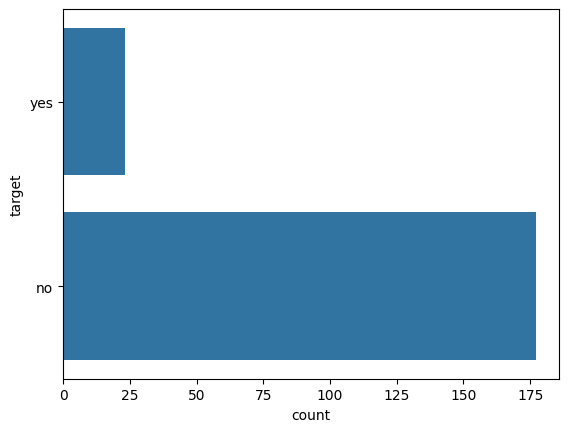

In [ ]:
# Plotting the distribution of target
# ---
#
sns.countplot(sample_df['target']);

In [ ]:
# sampling tweets with neutral sentiments
df_yes = df[df["target"] == 'yes']
df_yes = df_yes.sample(100)

# sampling tweets with negative sentiments
df_no = df[df["target"] == 'no']
df_no = df_no.sample(100)

# combining our dataframes
df = pd.concat([df_yes, df_no])
df.head()

,text,target
972,"Shout-out for https://t.co/Zgrf1IHWm7 🙌, inc. ...",yes
23,Watching a 29 year old woman with stage 4 ovar...,yes
125,This is the link to the column: https://t.co/F...,yes
696,"Also fun fact, my moms friend owned a health f...",yes
330,Ayurveda not only heal body but also mind and ...,yes


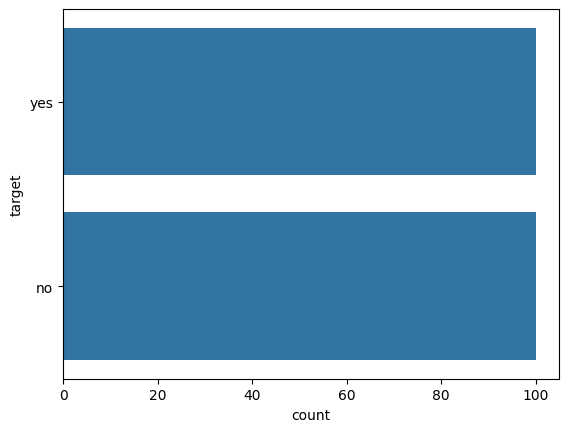

In [ ]:
# Previewing the distribution of sentiment
# ---
#
sns.countplot(df['target']);

We now have balanced data

### Step 2: Data preparation

#### Basic data cleaning

In [ ]:
# Trimming whitespaces in our target variable
# ---
#
df['target'] = df.target.str.strip()

# Checking our unique values
# ---
#
df.target.unique()

array(['yes', 'no'], dtype=object)

In [ ]:
# Let's check for missing values
# ---
#
df.isnull().sum()

,0
text,0
target,0


#### Text processing

In [ ]:
# We will create a custom function that will contain all the text cleaning
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.
# ---
#
def text_cleaning(text):
  # Removing url/links
  df['text'] = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+','', str(x)))

  # Removing @ and # characters and replacing them with space
  df['text'] = df.text.str.replace('#',' ')
  df['text'] = df.text.str.replace('@',' ')

  # Conversion to lowercase
  df['text'] = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing punctuation characters
  df['text'] = df.text.str.replace('[^\w\s]','')

  # Removing stop words
  df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # Lemmatization
  df['text'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
import re

In [ ]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 5-10 min.
# ---
#
df.text.apply(text_cleaning)
df.sample(5)

,text,target
721,whether believe climatechange it’s best agree ...,yes
719,*this chimes* positivity can’t cure cancer – n...,yes
1444,attention !!🗣 medical science done research in...,yes
610,"apricot kernel cure cancer. do, unfortunately,...",yes
279,&lt; melgnao wife yes please cure blood cancer...,no


#### Feature engineering

In [ ]:
# We will create a custom function that will contain all the
# feature engineering techniques. We can then use this function
# for cleaning new data.
# ---
#
def feature_engineering(text):
  # Length of text
  df['length_of_text'] = df.text.str.len()

  # Word count
  df['word_count'] = df.text.apply(lambda x: len(str(x).split(" ")))

  # Word density (Average no. of words / text)
  df['avg_word_length'] = df.text.apply(lambda x: avg_word(x))

  # Noun Count
  df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

  # Verb Count
  df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

  # Adjective Count / Text
  df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

  # Adverb Count / Text
  df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

  # Pronoun
  df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

  # Subjectivity
  df['subjectivity'] = df.text.apply(get_subjectivity)

  # Polarity
  df['polarity'] = df.text.apply(get_polarity)

In [ ]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
df.text.apply(feature_engineering)
df.sample(5)

,text,target,length_of_text,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
533,northkoreatimes northkorea : dogmeatt cure can...,yes,114,15,6.666667,7,3,3,0,0,0.0,0.0
1485,health juice part 2 diet natural fitness drink...,yes,92,16,4.812500,12,1,2,0,0,0.0,0.0
154,f.d.a. openly banned apricot seed laetrile ext...,yes,106,14,6.642857,8,3,1,1,0,0.0,0.0
702,"rt z_matshana: whisky better cure hiv, cancer ...",no,88,13,5.846154,8,2,3,1,0,0.0,0.0
942,autophagy could lead cure cancer spell end dia...,yes,126,17,6.470588,11,4,1,0,0,0.0,0.0


In [25]:
# Performing further feature engineering techniques
# ---
#

# Feature Construction: Word Level N-Gram TF-IDF Feature
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text)

# Feature Construction: Character Level N-Gram TF-IDF
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [26]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---
#
y = np.array(df['target'].replace(['yes', 'no'], ['0','1']))
y

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

In [27]:
# Let's prepare the constructed features for modeling
# ---
# We will select all variables but the target (which is the label) and text variables
# ---
#
X_metadata = np.array(df[df.columns.difference(['target', 'text'])])
X_metadata

array([[ 7.        ,  5.        ,  6.2       , ...,  0.        ,
         5.        , 50.        ],
       [ 2.        ,  1.        ,  5.04166667, ...,  0.        ,
         4.        , 24.        ],
       [ 8.        ,  1.        ,  6.29268293, ...,  0.        ,
         4.        , 41.        ],
       ...,
       [ 6.        ,  1.        ,  5.96666667, ...,  0.        ,
         4.        , 30.        ],
       [ 3.        ,  0.        ,  7.08      , ...,  0.        ,
         6.        , 25.        ],
       [ 6.        ,  4.        ,  5.6       , ...,  0.        ,
         5.        , 30.        ]])

In [29]:
import scipy


In [30]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---
#
X = scipy.sparse.hstack([df_word_vect, df_char_vect, X_metadata])
X


<200x2010 sparse matrix of type '<class 'numpy.float64'>'
	with 47676 stored elements in COOrdinate format>

### Step 3: Data modelling


In this step we use machine learning algorithms to train and test our sentiment analysis models.

In [31]:
# Splitting our data
# ---
#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Fitting our model
# ---
#

# Importing the algorithms
# ---
#
from sklearn.linear_model import LogisticRegression      # Logistic Regression Classifier
from sklearn.tree import DecisionTreeClassifier          # Decision Tree Classifier
from sklearn.svm import SVC                              # SVM Classifier
from sklearn.naive_bayes import MultinomialNB            # Naive Bayes Classifier
from sklearn.neighbors import KNeighborsClassifier       # KNN Classifier

# Ensemble classifiers
from sklearn.ensemble import BaggingClassifier           # Bagging Meta-Estimator Classifier
from sklearn.ensemble import RandomForestClassifier      # RandomForest Classifier
from sklearn.ensemble import AdaBoostClassifier          # AdaBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier  # AdaBoost GradientBoostingClassifier

# Instantiating our models
# ---
#
logistic_classifier = LogisticRegression(solver='saga', max_iter=800, multi_class='multinomial') # solver works well with a large dataset like ours
decision_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
naive_classifier = MultinomialNB()

bagging_meta_classifier = BaggingClassifier()
random_forest_classifier = RandomForestClassifier()
ada_boost_classifier = AdaBoostClassifier(random_state=42)
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Training our models
# ---
#
logistic_classifier.fit(X_train, y_train)
decision_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
naive_classifier.fit(X_train, y_train)

bagging_meta_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
ada_boost_classifier.fit(X_train, y_train)
gbm_classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GradientBoostingClassifier(random_state=42)

In [33]:
# Making predictions
# ---
#
logistic_y_prediction = logistic_classifier.predict(X_test)
decision_y_prediction = decision_classifier.predict(X_test)
svm_y_prediction = svm_classifier.predict(X_test)
knn_y_prediction = knn_classifier.predict(X_test)
naive_y_prediction = naive_classifier.predict(X_test)

bagging_y_classifier = bagging_meta_classifier.predict(X_test)
random_forest_y_classifier = random_forest_classifier.predict(X_test)
ada_boost_y_classifier = ada_boost_classifier.predict(X_test)
gbm_y_classifier = gbm_classifier.predict(X_test)

In [34]:
# Evaluating the Models
# ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Accuracy scores
#
print("Logistic Regression Classifier", accuracy_score(logistic_y_prediction, y_test))
print("Decision Trees Classifier", accuracy_score(decision_y_prediction, y_test))
print("SVN Classifier", accuracy_score(svm_y_prediction, y_test))
print("KNN Classifier", accuracy_score(knn_y_prediction, y_test))
print("Naive Bayes Classifier", accuracy_score(naive_y_prediction, y_test))

print("Bagging Classifier", accuracy_score(bagging_y_classifier, y_test))
print("Random Forest Classifier", accuracy_score(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", accuracy_score(ada_boost_y_classifier, y_test))
print("GBM Classifier", accuracy_score(gbm_y_classifier, y_test))

Logistic Regression Classifier 0.625
Decision Trees Classifier 0.65
SVN Classifier 0.5
KNN Classifier 0.575
Naive Bayes Classifier 0.6
Bagging Classifier 0.6
Random Forest Classifier 0.65
Ada Boost Classifier 0.5
GBM Classifier 0.55


In [35]:
# Confusion matrix
# ---
# Regardless of the size of the confusion matrix, the method for intepretation is the same.
# The left-hand side contains the predicted values and the actual class labels run across the top.
# The instances that the classifier has correctly predicted run diagonally from the top-left
# to the bottom-right.
# ---
#
print('Logistic Regression Classifier:')
print(confusion_matrix(logistic_y_prediction, y_test))

print('Decision Trees Classifier:')
print(confusion_matrix(decision_y_prediction, y_test))

print('SVN Classifier:')
print(confusion_matrix(svm_y_prediction, y_test))

print('KNN Classifier:')
print(confusion_matrix(knn_y_prediction, y_test))

print('Naive Bayes Classifier:')
print(confusion_matrix(naive_y_prediction, y_test))

print('Bagging Classifier:')
print(confusion_matrix(bagging_y_classifier, y_test))

print('Random Forest Classifier:')
print(confusion_matrix(random_forest_y_classifier, y_test))

print('Ada Boost Classifier:')
print(confusion_matrix(ada_boost_y_classifier, y_test))

print('GBM Classifier:')
print(confusion_matrix(gbm_y_classifier, y_test))

Logistic Regression Classifier:
[[11  5]
 [10 14]]
Decision Trees Classifier:
[[12  5]
 [ 9 14]]
SVN Classifier:
[[ 4  3]
 [17 16]]
KNN Classifier:
[[11  7]
 [10 12]]
Naive Bayes Classifier:
[[19 14]
 [ 2  5]]
Bagging Classifier:
[[16 11]
 [ 5  8]]
Random Forest Classifier:
[[15  8]
 [ 6 11]]
Ada Boost Classifier:
[[12 11]
 [ 9  8]]
GBM Classifier:
[[14 11]
 [ 7  8]]


In [36]:
# Classification Reports
# ---
#
print("Logistic Regression Classifier", classification_report(logistic_y_prediction, y_test))
print("Decision Trees Classifier", classification_report(decision_y_prediction, y_test))
print("SVN Classifier", classification_report(svm_y_prediction, y_test))
print("KNN Classifier", classification_report(knn_y_prediction, y_test))
print("Naive Bayes Classifier", classification_report(naive_y_prediction, y_test))

print("Bagging Classifier", classification_report(bagging_y_classifier, y_test))
print("Random Forest Classifier", classification_report(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", classification_report(ada_boost_y_classifier, y_test))
print("GBM Classifier", classification_report(gbm_y_classifier, y_test))

Logistic Regression Classifier               precision    recall  f1-score   support

           0       0.52      0.69      0.59        16
           1       0.74      0.58      0.65        24

    accuracy                           0.62        40
   macro avg       0.63      0.64      0.62        40
weighted avg       0.65      0.62      0.63        40

Decision Trees Classifier               precision    recall  f1-score   support

           0       0.57      0.71      0.63        17
           1       0.74      0.61      0.67        23

    accuracy                           0.65        40
   macro avg       0.65      0.66      0.65        40
weighted avg       0.67      0.65      0.65        40

SVN Classifier               precision    recall  f1-score   support

           0       0.19      0.57      0.29         7
           1       0.84      0.48      0.62        33

    accuracy                           0.50        40
   macro avg       0.52      0.53      0.45        40
we

Evaluation our Models

- Accuracy: the percentage of texts that were assigned the correct topic.
- Precision: the percentage of texts the classifier classified correctly out of the total number of texts it predicted for each topic
- Recall: the percentage of texts the model predicted for each topic out of the total number of texts it should have predicted for that topic.
- F1 Score: the average of both precision and recall.